# Proyek Klasifikasi Gambar: Garbage Classification
- **Nama:** Muhammad Haniff
- **Email:** toha.hanif341@gmail.com
- **ID Dicoding:** muhammad_haniff_7q8U

## Import Semua Packages/Library yang Digunakan

In [1]:
import zipfile,os
import shutil
from shutil import copyfile
from tqdm.notebook import tqdm as tq

import pandas as pd
import numpy as np
import random, re

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from skimage import io, img_as_ubyte
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
#from tensorflow.keras.layers import GlobalAveragePooling2D
#from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications import DenseNet121
#from tensorflow.keras.applications import EfficientNetV2B1
#from torchvision.models import resnet50, ResNet50_Weights
#from torchvision import transforms

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.preprocessing import image



import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

## Data Preparation

### Download Data

Dataset diambil dari Kaggle pada link
https://www.kaggle.com/datasets/mostafaabla/garbage-classification/code?datasetId=1115942&sortBy=relevance

In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

In [ ]:
!unzip "garbage-classification.zip" -d "garbage_classification"

### Dataset Overview

In [9]:
dataset_dir = "garbage_classification"
os.listdir(dataset_dir)

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [10]:
categories = ['battery','biological','brown-glass', 'cardboard', 'clothes', 'green-glass','metal',
 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [11]:
def print_images_resolution(directory):
    unique_sizes = list()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.append(img.size)

        print('Pixel Size of 5 Samples')
        for size in unique_sizes[:5]:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [12]:
print_images_resolution(dataset_dir)

battery: 945
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
biological: 985
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
brown-glass: 607
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
cardboard: 891
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
clothes: 5325
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
green-glass: 629
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
metal: 769
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
paper: 1050
Pixel Size of 5 Samples
- (280, 180)
- (220, 165)
- (275, 183)
- (275, 183)
- (224, 224)
---------------
plastic: 865
Pixel Size of 5 Samples
- (280, 

In [13]:
# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

In [14]:
df.head()

,path,file_name,labels
0,garbage_classification\battery\battery1.jpg,battery1.jpg,garbage_classification\battery
1,garbage_classification\battery\battery10.jpg,battery10.jpg,garbage_classification\battery
2,garbage_classification\battery\battery100.jpg,battery100.jpg,garbage_classification\battery
3,garbage_classification\battery\battery101.jpg,battery101.jpg,garbage_classification\battery
4,garbage_classification\battery\battery102.jpg,battery102.jpg,garbage_classification\battery


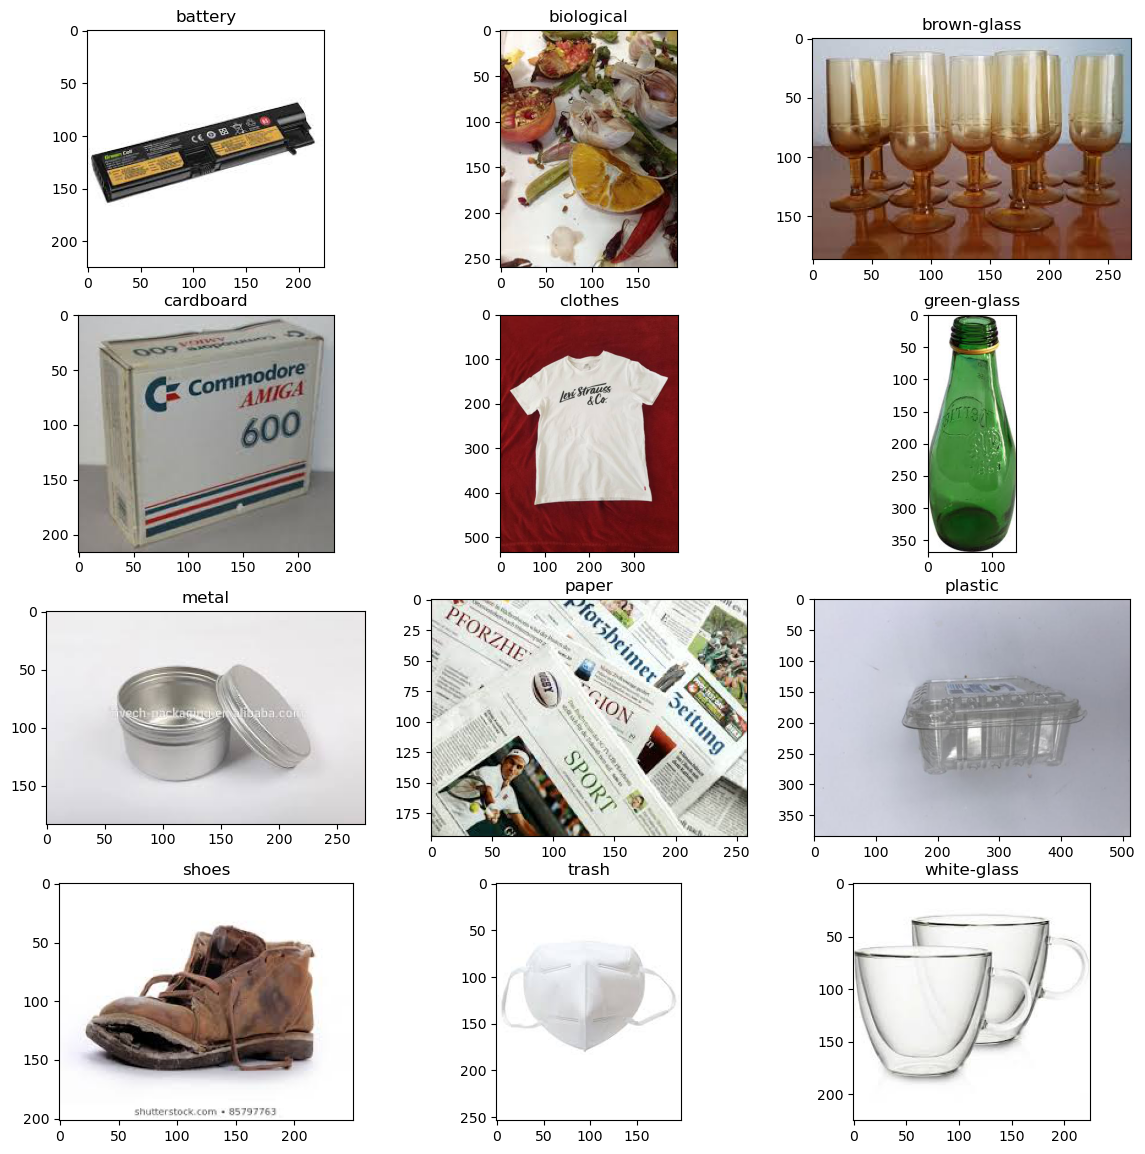

In [15]:
# Create the figure and subplots
fig, axs = plt.subplots(4, 3, figsize=(14, 10))

for i, class_name in enumerate(categories):
    class_dir = os.path.join(dataset_dir, class_name)
    image_path = os.path.join(class_dir, np.random.choice(os.listdir(class_dir)))  #Ambil gambar random
    # Load and display the image
    img = plt.imread(image_path)
    axs.flat[i].imshow(img)
    axs.flat[i].set_title(class_name)
    plt.subplots_adjust(top=1.2)  # Adjust the top margin to create space


plt.show()

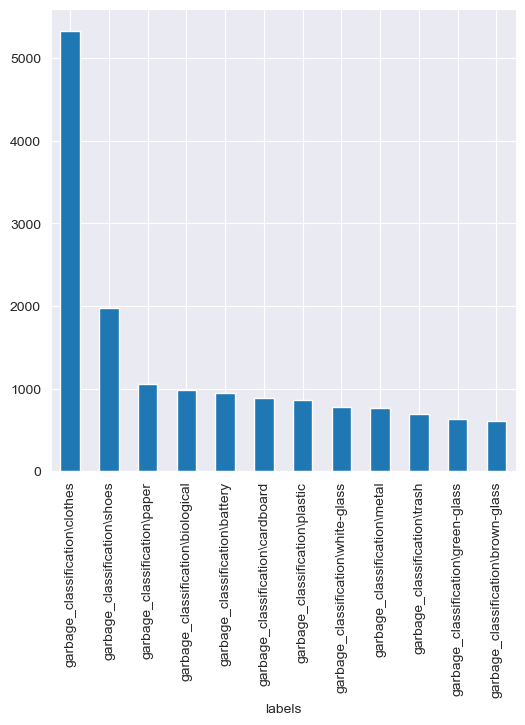

In [16]:
# Plot the distribution of imagesbar across the classes
Label = df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data =df['labels'].value_counts().plot.bar()

In [17]:
df['labels'].value_counts()

labels
garbage_classification\clothes        5325
garbage_classification\shoes          1977
garbage_classification\paper          1050
garbage_classification\biological      985
garbage_classification\battery         945
garbage_classification\cardboard       891
garbage_classification\plastic         865
garbage_classification\white-glass     775
garbage_classification\metal           769
garbage_classification\trash           697
garbage_classification\green-glass     629
garbage_classification\brown-glass     607
Name: count, dtype: int64

### Data Preprocessing

#### Handle Imalance

- Karena terdapat 12 class, dimana akan dijadikan setiap class memiliki 1000 gambar
- class dengan data lebih dari 1000, hanya akan diambil 1000 gambar
- class dengan data gambar <1000 akan dilakukan image augmentation

Text(0, 0, 'Total:\n15515')

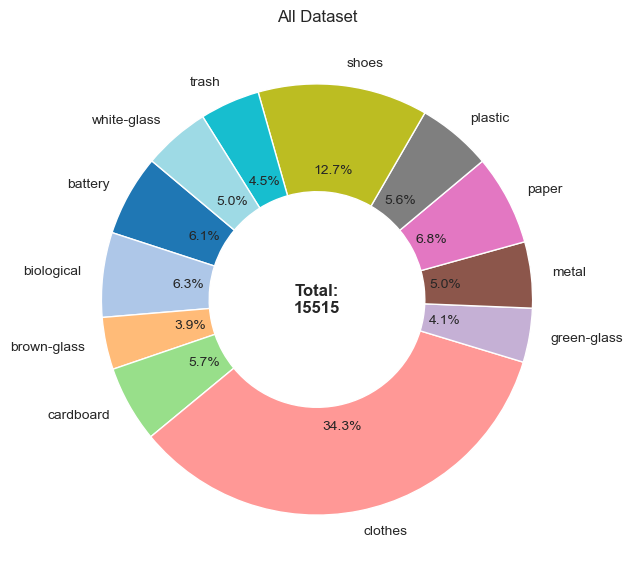

In [18]:
fig, axes = plt.subplots(1,1, figsize=(10, 7))
color = cm.get_cmap('tab20', len(categories))

axes.pie(df.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes.set_title("All Dataset")
axes.text(0, 0, f'Total:\n{df.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

##### Data Augmentation

In [19]:
def anticlockwise_rotation(img):
    degrees = random.choice([90, 180, 270])
    return img.rotate(degrees)

def clockwise_rotation(img):
    degrees = random.choice([90, 180, 270])
    return img.rotate(-degrees)

def flip_up_down(img):
    return ImageOps.flip(img)

def add_brightness(img):
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.5, 1.1)  # Brightness factor
    return enhancer.enhance(factor)

def blur_image(img):
    return img.filter(ImageFilter.BLUR)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    #img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    #img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [20]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'flip up down': flip_up_down,
    'add brightness': add_brightness,
    'blurring image': blur_image,
    'shear image': sheared,
    'warp shift': warp_shift
}

def augment_image(img):
    transformation_count = random.randint(1, len(transformations))
    for _ in range(transformation_count):
        key = random.choice(list(transformations))
        img = transformations[key](img)
    return img 

In [21]:
def process_images(source_class_dir, target_class_dir):
    images = [os.path.join(source_class_dir, fname) for fname in os.listdir(source_class_dir) if fname.endswith(('.jpg', '.png'))]
    if not os.path.exists(target_class_dir):
        os.makedirs(target_class_dir)

    num_original_images = len(images)
    if num_original_images > 1000:
        selected_images = random.sample(images, 1000)
        for i, img_path in enumerate(selected_images):
            shutil.copy(img_path, os.path.join(target_class_dir, f'image_{i}.jpg'))
    else:
        # Copy original images
        for i, img_path in enumerate(images):
            shutil.copy(img_path, os.path.join(target_class_dir, f'image_{i}.jpg'))

        # Generate augmented images to make up the difference
        num_augmentations_needed = 1000 - num_original_images
        augmented_images_count = 0

        while augmented_images_count < num_augmentations_needed:
             try:
                original_image = Image.open(random.choice(images))
                original_image = original_image.convert('RGB')  # Ensure image is in RGB mode
                original_image = original_image.resize(target_size)  # Resize the image
                augmented_image = augment_image(original_image)
                new_image_path = os.path.join(target_class_dir, f'augmented_image_{i + augmented_images_count}.jpg')
                augmented_image.save(new_image_path)
                augmented_images_count += 1
             except Exception as e:
                pass
    print("Image Succesfully generated")

**Hapus kelas dengan data terendah**
* Sebetulnya ini coba langkah terakhir biar dapat val accuracy 95% kak, mengurangi jumlah kelas Huhu, udah beberapa kali dengan data yg apa adanya hanya mentok di val_accuracy 93% huhu
* Hapus kategori dengan gambar dengan akurasi kecil
    * white-glass : karena gambar transparan sehingga sukar di klasifikasi
    * metal : karena adanya pantulan, dan variasi metal yg cukup banyak dalam direktori

In [22]:
source_dir = dataset_dir  # Source dataset path
clean_dataset_dir = 'dataset_clean'  # Destination path for the balanced dataset
target_size = (224, 224)

# Exclude kelas yg tidak dinginkan
excluded_classes = ['white-glass', 'metal']

classes = os.listdir(source_dir)
for class_name in classes:
    if class_name in excluded_classes:
        continue  # Skip classes with fewer images
    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(clean_dataset_dir, class_name)
    process_images(source_class_dir, target_class_dir)

Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated
Image Succesfully generated


In [23]:
os.listdir(clean_dataset_dir)

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [24]:
# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(clean_dataset_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

df_clean = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

In [25]:
df_clean.sample(5)

,path,file_name,labels
3733,dataset_clean\cardboard\image_660.jpg,image_660.jpg,cardboard
9136,dataset_clean\trash\augmented_image_832.jpg,augmented_image_832.jpg,trash
4563,dataset_clean\clothes\image_605.jpg,image_605.jpg,clothes
785,dataset_clean\battery\image_756.jpg,image_756.jpg,battery
6919,dataset_clean\paper\image_926.jpg,image_926.jpg,paper


In [26]:
categories = ['battery','biological','brown-glass', 'cardboard', 'clothes', 'green-glass', 'paper', 'plastic', 'shoes', 'trash']

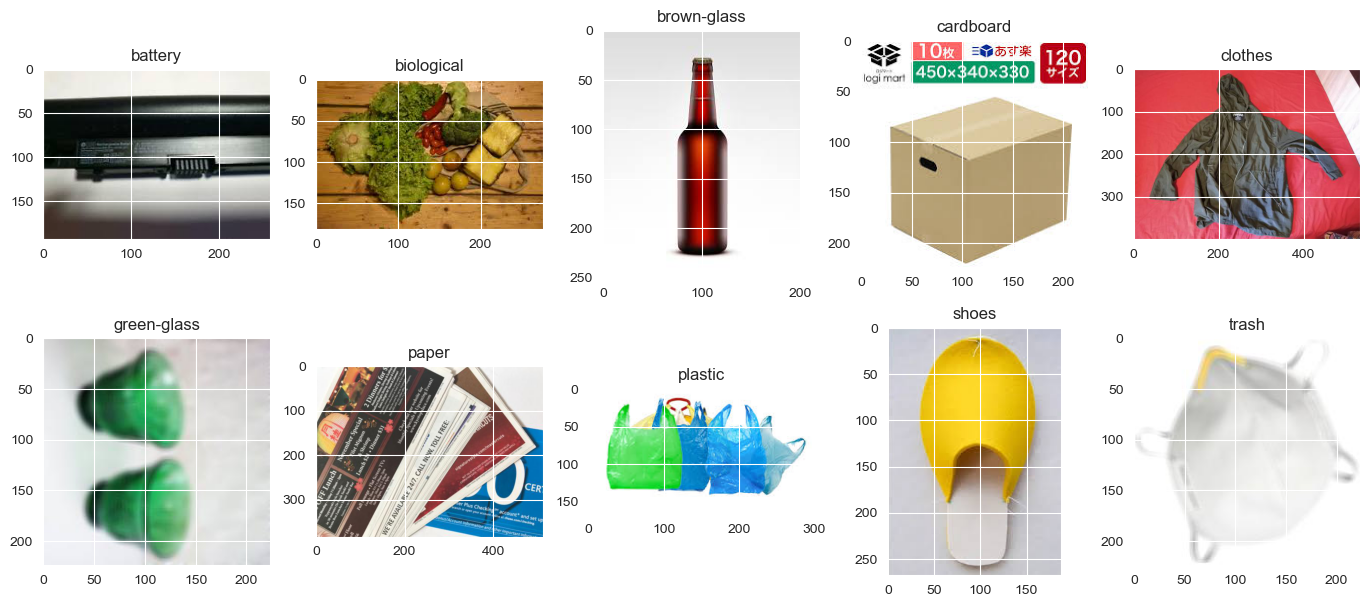

In [27]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 5, figsize=(17, 5))

for i, class_name in enumerate(categories):
    class_dir = os.path.join(clean_dataset_dir, class_name)
    image_path = os.path.join(class_dir, np.random.choice(os.listdir(class_dir)))  #Ambil gambar random
    # Load and display the image
    img = plt.imread(image_path)
    axs.flat[i].imshow(img)
    axs.flat[i].set_title(class_name)
    plt.subplots_adjust(top=1.2)  # Adjust the top margin to create space


plt.show()

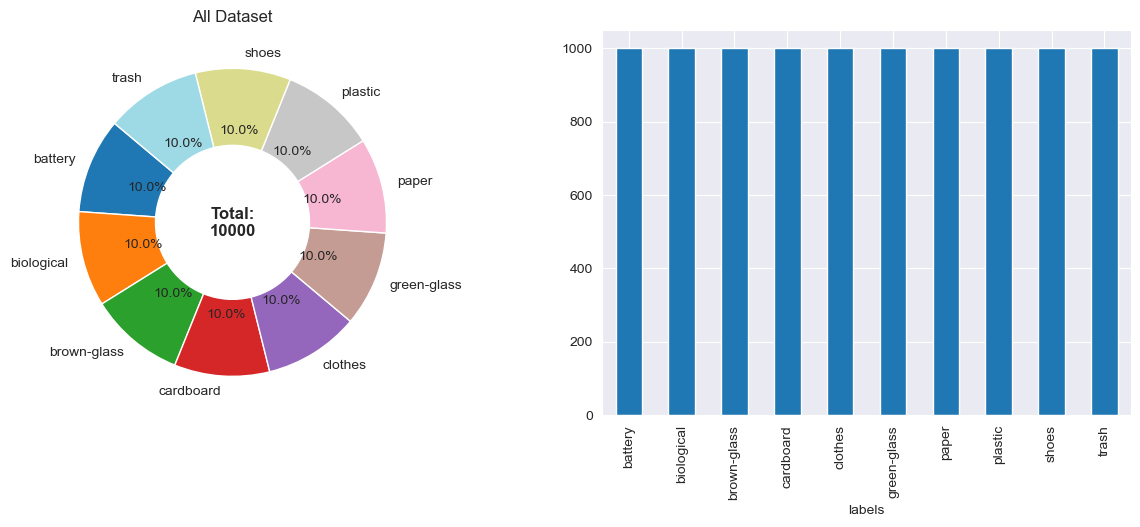

In [28]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
color = cm.get_cmap('tab20', len(categories))

axes[0].pie(df_clean.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[0].set_title("All Dataset")
axes[0].text(0, 0, f'Total:\n{df_clean.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

axes[1] = df_clean['labels'].value_counts().plot.bar()

#### Data Splitting

In [29]:
df_clean.head()

,path,file_name,labels
0,dataset_clean\battery\augmented_image_944.jpg,augmented_image_944.jpg,battery
1,dataset_clean\battery\augmented_image_945.jpg,augmented_image_945.jpg,battery
2,dataset_clean\battery\augmented_image_946.jpg,augmented_image_946.jpg,battery
3,dataset_clean\battery\augmented_image_947.jpg,augmented_image_947.jpg,battery
4,dataset_clean\battery\augmented_image_948.jpg,augmented_image_948.jpg,battery


In [30]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df_clean['path']
y= df_clean['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [31]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})


set    labels     
test   battery        208
       biological     202
       brown-glass    192
       cardboard      201
       clothes        209
       green-glass    186
       paper          211
       plastic        204
       shoes          212
       trash          175
train  battery        792
       biological     798
       brown-glass    808
       cardboard      799
       clothes        791
       green-glass    814
       paper          789
       plastic        796
       shoes          788
       trash          825
dtype: int64 


Total size 10000
train size 8000
test size 2000



<Axes: >

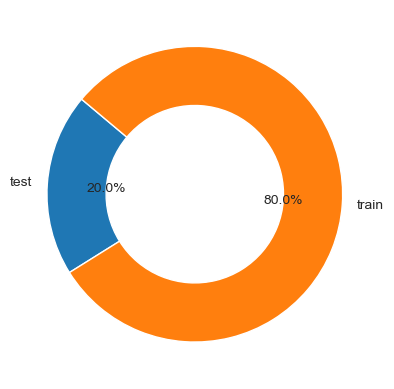

In [32]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')
print('Total size', len(df_all))
print('train size', len(df_tr))
print('test size', len(df_te))
print('===================================================== \n')
df_all.groupby('set').size().plot.pie(autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.4})

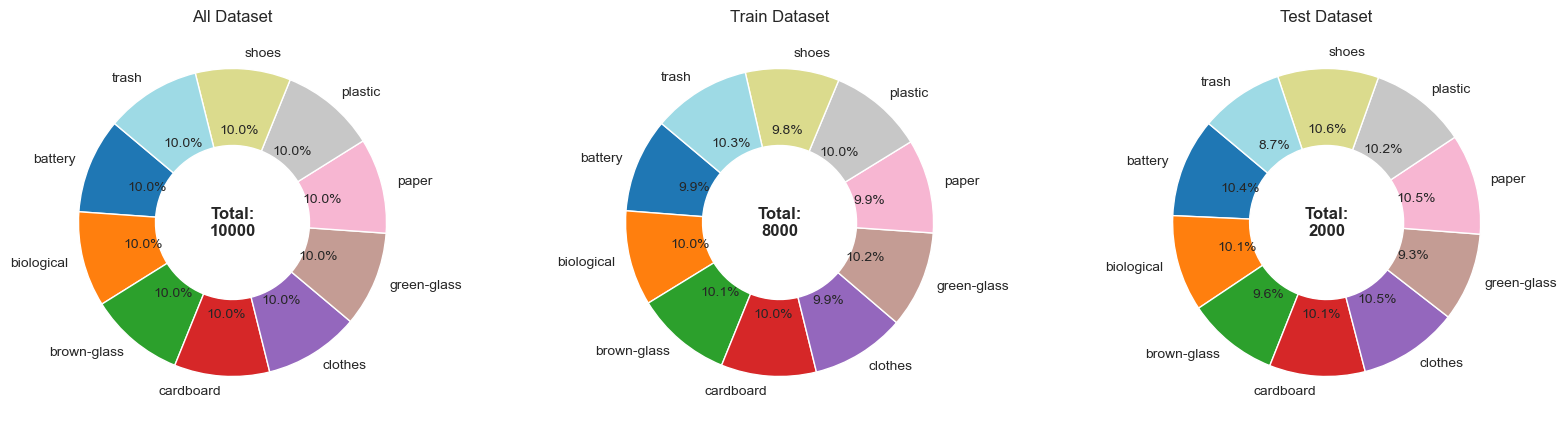

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
color = cm.get_cmap('tab20', len(categories))

axes[0].pie(df_all.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[0].set_title("All Dataset")
axes[0].text(0, 0, f'Total:\n{df_all.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

axes[1].pie(df_tr.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[1].set_title("Train Dataset")
axes[1].text(0, 0, f'Total:\n{df_tr.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

axes[2].pie(df_te.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[2].set_title("Test Dataset")
axes[2].text(0, 0, f'Total:\n{df_te.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')
plt.show()

#### Menyimpan Data Splitting ke Directory

agar mudah pindah pindah penyedia free gpu kak huhu

In [64]:
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset_Final3"

for index, row in tq(df_all.iterrows()):
    # Normalize file path
    file_path = os.path.normpath(row['path'])

    if not os.path.exists(file_path):
        file_path = os.path.normpath(os.path.join(clean_dataset_dir, row['labels'], row['image'].split('.')[0]))

    # Create destination directory if it doesn't exist
    destination_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Determine the destination file path
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(destination_dir, destination_file_name)

    # Copy the file if it doesn't already exist in the destination
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [34]:
cek_dir = "Dataset_Final3/test/"
os.listdir(cek_dir)

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [36]:
TRAIN_DIR = 'Dataset_Final3/train'
TEST_DIR = 'Dataset_Final3/test'

train_battery = os.path.join(TRAIN_DIR + '/battery')
train_biological = os.path.join(TRAIN_DIR + '/biological')
train_cardboard = os.path.join(TRAIN_DIR + '/cardboard')
train_clothes = os.path.join(TRAIN_DIR + '/clothes')
train_brown_glass = os.path.join(TRAIN_DIR + '/brown-glass')
train_green_glass = os.path.join(TRAIN_DIR + '/green-glass')
train_paper = os.path.join(TRAIN_DIR + '/paper')
train_plastic = os.path.join(TRAIN_DIR + '/plastic')
train_shoes = os.path.join(TRAIN_DIR + '/shoes')
train_trash = os.path.join(TRAIN_DIR + '/trash')


test_battery = os.path.join(TEST_DIR + '/battery')
test_biological = os.path.join(TEST_DIR + '/biological')
test_cardboard = os.path.join(TEST_DIR + '/cardboard')
test_clothes = os.path.join(TEST_DIR + '/clothes')
test_brown_glass = os.path.join(TEST_DIR + '/brown-glass')
test_green_glass = os.path.join(TEST_DIR + '/green-glass')
test_paper = os.path.join(TEST_DIR + '/paper')
test_plastic = os.path.join(TEST_DIR + '/plastic')
test_shoes = os.path.join(TEST_DIR + '/shoes')
test_trash = os.path.join(TEST_DIR + '/trash')

print("Total number of battery images in training set: ",len(os.listdir(train_battery)))
print("Total number of biological images in training set: ",len(os.listdir(train_biological)))
print("Total number of cardboard images in training set: ",len(os.listdir(train_cardboard)))
print("Total number of clothes images in training set: ",len(os.listdir(train_clothes)))
print("Total number of green-glass images in training set: ",len(os.listdir(train_green_glass)))
print("Total number of paper images in training set: ",len(os.listdir(train_paper)))
print("Total number of brown-glass images in training set: ",len(os.listdir(train_brown_glass)))
print("Total number of plastic images in training set: ",len(os.listdir(train_plastic)))
print("Total number of shoes images in training set: ",len(os.listdir(train_shoes)))
print("Total number of trash images in training set: ",len(os.listdir(train_trash)))
print("\n")
print("Total number of battery images in test set: ", len(os.listdir(test_battery)))
print("Total number of biological images in test set: ", len(os.listdir(test_biological)))
print("Total number of cardboard images in test set: ", len(os.listdir(test_cardboard)))
print("Total number of clothes images in test set: ", len(os.listdir(test_clothes)))
print("Total number of brown-glass images in test set: ",len(os.listdir(test_brown_glass)))
print("Total number of green-glass images in test set: ",len(os.listdir(test_green_glass)))
print("Total number of paper images in test set: ", len(os.listdir(test_paper)))
print("Total number of plastic images in test set: ", len(os.listdir(test_plastic)))
print("Total number of shoes images in test set: ", len(os.listdir(test_shoes)))
print("Total number of trash images in test set: ", len(os.listdir(test_trash)))

Total number of battery images in training set:  792
Total number of biological images in training set:  798
Total number of cardboard images in training set:  799
Total number of clothes images in training set:  791
Total number of green-glass images in training set:  814
Total number of paper images in training set:  789
Total number of brown-glass images in training set:  808
Total number of plastic images in training set:  796
Total number of shoes images in training set:  788
Total number of trash images in training set:  825


Total number of battery images in test set:  208
Total number of biological images in test set:  202
Total number of cardboard images in test set:  201
Total number of clothes images in test set:  209
Total number of brown-glass images in test set:  192
Total number of green-glass images in test set:  186
Total number of paper images in test set:  211
Total number of plastic images in test set:  204
Total number of shoes images in test set:  212
Total numbe

## Image Data Generator

ada beberapa coding yg oleh di skip kak soalnya saya coba beberapa penyedia gpu gratis hehe

In [11]:
cek_dir = '/kaggle/input/garbage-dataset-10class-10k-2/Dataset_Final3/train'
os.listdir(cek_dir)

['biological',
 'paper',
 'brown-glass',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic',
 'green-glass']

In [12]:
# Define training and test directories
TRAIN_DIR = '/kaggle/input/garbage-dataset-10class-10k-2/Dataset_Final3/train'
TEST_DIR = '/kaggle/input/garbage-dataset-10class-10k-2/Dataset_Final3/test'

train_battery = os.path.join(TRAIN_DIR + '/battery')
train_biological = os.path.join(TRAIN_DIR + '/biological')
train_cardboard = os.path.join(TRAIN_DIR + '/cardboard')
train_clothes = os.path.join(TRAIN_DIR + '/clothes')
train_brown_glass = os.path.join(TRAIN_DIR + '/brown-glass')
train_green_glass = os.path.join(TRAIN_DIR + '/green-glass')
train_paper = os.path.join(TRAIN_DIR + '/paper')
train_plastic = os.path.join(TRAIN_DIR + '/plastic')
train_shoes = os.path.join(TRAIN_DIR + '/shoes')
train_trash = os.path.join(TRAIN_DIR + '/trash')


test_battery = os.path.join(TEST_DIR + '/battery')
test_biological = os.path.join(TEST_DIR + '/biological')
test_cardboard = os.path.join(TEST_DIR + '/cardboard')
test_clothes = os.path.join(TEST_DIR + '/clothes')
test_brown_glass = os.path.join(TEST_DIR + '/brown-glass')
test_green_glass = os.path.join(TEST_DIR + '/green-glass')
test_paper = os.path.join(TEST_DIR + '/paper')
test_plastic = os.path.join(TEST_DIR + '/plastic')
test_shoes = os.path.join(TEST_DIR + '/shoes')
test_trash = os.path.join(TEST_DIR + '/trash')

print("Total number of battery images in training set: ",len(os.listdir(train_battery)))
print("Total number of biological images in training set: ",len(os.listdir(train_biological)))
print("Total number of cardboard images in training set: ",len(os.listdir(train_cardboard)))
print("Total number of clothes images in training set: ",len(os.listdir(train_clothes)))
print("Total number of green-glass images in training set: ",len(os.listdir(train_green_glass)))
print("Total number of paper images in training set: ",len(os.listdir(train_paper)))
print("Total number of brown-glass images in training set: ",len(os.listdir(train_brown_glass)))
print("Total number of plastic images in training set: ",len(os.listdir(train_plastic)))
print("Total number of shoes images in training set: ",len(os.listdir(train_shoes)))
print("Total number of trash images in training set: ",len(os.listdir(train_trash)))
print("\n")
print("Total number of battery images in test set: ", len(os.listdir(test_battery)))
print("Total number of biological images in test set: ", len(os.listdir(test_biological)))
print("Total number of cardboard images in test set: ", len(os.listdir(test_cardboard)))
print("Total number of clothes images in test set: ", len(os.listdir(test_clothes)))
print("Total number of brown-glass images in test set: ",len(os.listdir(test_brown_glass)))
print("Total number of green-glass images in test set: ",len(os.listdir(test_green_glass)))
print("Total number of paper images in test set: ", len(os.listdir(test_paper)))
print("Total number of plastic images in test set: ", len(os.listdir(test_plastic)))
print("Total number of shoes images in test set: ", len(os.listdir(test_shoes)))
print("Total number of trash images in test set: ", len(os.listdir(test_trash)))

Total number of battery images in training set:  792
Total number of biological images in training set:  798
Total number of cardboard images in training set:  799
Total number of clothes images in training set:  791
Total number of green-glass images in training set:  814
Total number of paper images in training set:  789
Total number of brown-glass images in training set:  808
Total number of plastic images in training set:  796
Total number of shoes images in training set:  788
Total number of trash images in training set:  825


Total number of battery images in test set:  208
Total number of biological images in test set:  202
Total number of cardboard images in test set:  201
Total number of clothes images in test set:  209
Total number of brown-glass images in test set:  192
Total number of green-glass images in test set:  186
Total number of paper images in test set:  211
Total number of plastic images in test set:  204
Total number of shoes images in test set:  212
Total numbe

In [13]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle = False
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [14]:
print("classes: ", train_generator.class_indices)

classes:  {'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


## Modelling

#### Fine Tunning ke-4

sempat coba beberapa model kak, yg bagus itu pakai finetunning mobilenet;
- model5 ini val_accuracy baru 93%, hasil evaluasinya dikembalikan ke data preprocessing
    - modelnya dihapus kak, biar ga bingung dan lebih rapih notebooknya 
- model6 sudah mencapai va_accuracy 95%

In [6]:
input_shape = (224, 224, 3)

mobile_netV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobile_netV2.trainable = False

model6 = Sequential([
    Input(shape=input_shape),
    mobile_netV2,
    Conv2D(1024, (4, 4),padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

In [7]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        20972544  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              9438208   
                                                                 
 batch_normalization_2 (Bat  (None, 1024)             

In [8]:
model6.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

## Train Model

### Train Model ke 6 : model5

ini yg model5 gajadi dipake kak, soalnya gasampe 95%. Jadi saya hapus Progress pelatihannya, berikut hasil evaluasi saja, untuk kembali ke data preprocessinng, dimana kelas data dengan akurasi terendah dilakukan tinjauan ulang

2400/2400 [==============================] - 300s 125ms/step


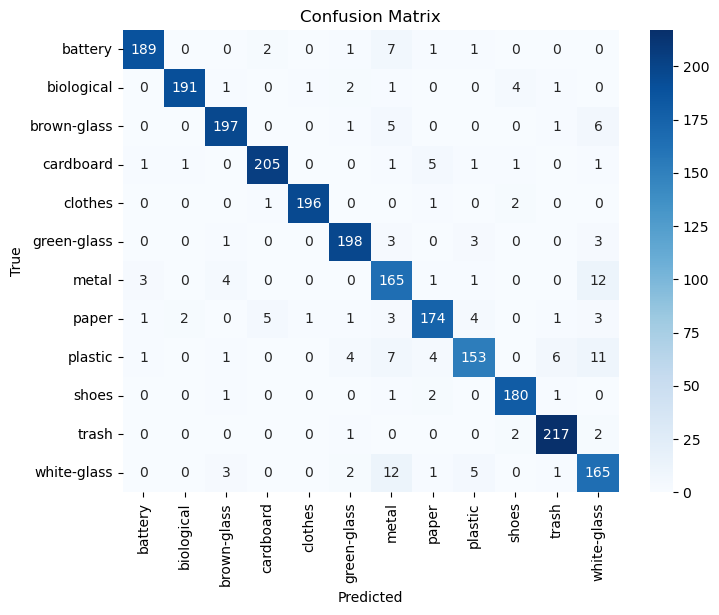

              precision    recall  f1-score   support



     battery       0.97      0.94      0.95       201

  biological       0.98      0.95      0.97       201

 brown-glass       0.95      0.94      0.94       210

   cardboard       0.96      0.95      0.96       216

     clothes       0.99      0.98      0.98       200

 green-glass       0.94      0.95      0.95       208

       metal       0.80      0.89      0.84       186

       paper       0.92      0.89      0.91       195

     plastic       0.91      0.82      0.86       187

       shoes       0.95      0.97      0.96       185

       trash       0.95      0.98      0.96       222

 white-glass       0.81      0.87      0.84       189



    accuracy                           0.93      2400

   macro avg       0.93      0.93      0.93      2400

weighted avg       0.93      0.93      0.93      2400




In [17]:
predictions = model5.predict(val_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(val_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

### Train Final Model : model6

In [16]:
count_battery = len(os.listdir(train_battery))
count_biological = len(os.listdir(train_biological))
count_brown_glass = len(os.listdir(train_brown_glass))
count_cardboard = len(os.listdir(train_cardboard))
count_clothes = len(os.listdir(train_clothes))
count_green_glass = len(os.listdir(train_green_glass))
count_paper = len(os.listdir(train_paper))
count_plastic = len(os.listdir(train_plastic))
count_shoes = len(os.listdir(train_shoes))
count_trash = len(os.listdir(train_trash))


total_images = (count_battery + count_biological + count_brown_glass +
                count_cardboard + count_clothes + count_green_glass + 
                count_paper + count_plastic + count_shoes + count_trash)

weight_battery = (1 / count_battery) * total_images / 10.0
weight_biological = (1 / count_biological) * total_images / 10.0
weight_brown_glass = (1 / count_brown_glass) * total_images / 10.0
weight_cardboard = (1 / count_cardboard) * total_images / 10.0
weight_clothes = (1 / count_clothes) * total_images / 10.0
weight_green_glass = (1 / count_green_glass) * total_images / 10.0
weight_paper = (1 / count_paper) * total_images / 10.0
weight_plastic = (1 / count_plastic) * total_images / 10.0
weight_shoes = (1 / count_shoes) * total_images / 10.0
weight_trash = (1 / count_trash) * total_images / 10.0

class_weights = {
    0: weight_battery,
    1: weight_biological,
    2: weight_brown_glass,
    3: weight_cardboard,
    4: weight_clothes,
    5: weight_green_glass,
    6: weight_paper,
    7: weight_plastic,
    8: weight_shoes,
    9: weight_trash,
    }

print("Class Weights:", class_weights)

Class Weights: {0: 1.0101010101010102, 1: 1.0025062656641603, 2: 0.9900990099009901, 3: 1.0012515644555695, 4: 1.0113780025284451, 5: 0.9828009828009827, 6: 1.0139416983523446, 7: 1.0050251256281408, 8: 1.015228426395939, 9: 0.9696969696969697}


In [17]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=1,
        verbose=1,
        factor=0.5,
        min_lr=0.0000001
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_model_MobileNetV2_5.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

In [18]:
BATCH_SIZE = 64

history8 = model6.fit(train_generator,
                      epochs = 20,
                      batch_size = BATCH_SIZE,
                      validation_data=test_generator,
                      class_weight = class_weights,
                      callbacks=[callbacks])

Epoch 1/20


I0000 00:00:1726129449.383301     180 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - ETA: 0s - loss: 1.1167 - accuracy: 0.7885
Epoch 1: val_accuracy improved from -inf to 0.82900, saving model to best_model_MobileNetV2_5.h5
125/125 [==============================] - 161s 1s/step - loss: 1.1167 - accuracy: 0.7885 - val_loss: 2.0874 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8894
Epoch 2: val_accuracy improved from 0.82900 to 0.84700, saving model to best_model_MobileNetV2_5.h5
125/125 [==============================] - 120s 956ms/step - loss: 0.5239 - accuracy: 0.8894 - val_loss: 1.2589 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9260
Epoch 3: val_accuracy improved from 0.84700 to 0.89100, saving model to best_model_MobileNetV2_5.h5
125/125 [==============================] - 120s 960ms/step - loss: 0.2969 - accuracy: 0.9260 - val_loss: 0.4688 - val_accuracy: 0.891

## Evaluasi dan Visualisasi

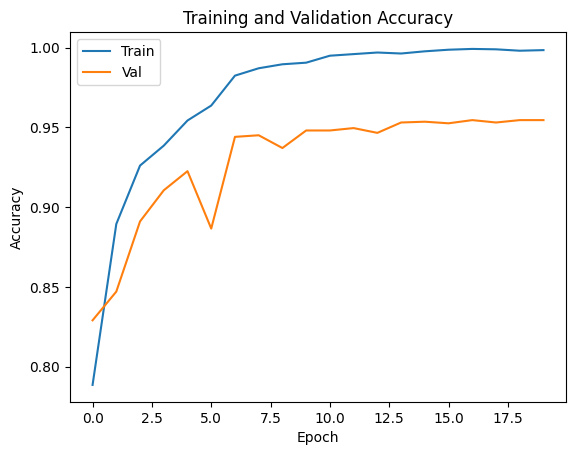

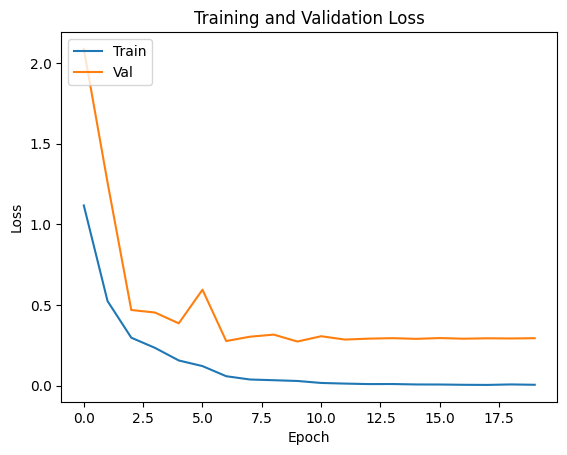

In [20]:
# Plot training and validation accuracy
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
IMG_SIZE = (224, 224)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle = False
)

Found 2000 images belonging to 10 classes.


2000/2000 [==============================] - 19s 9ms/step


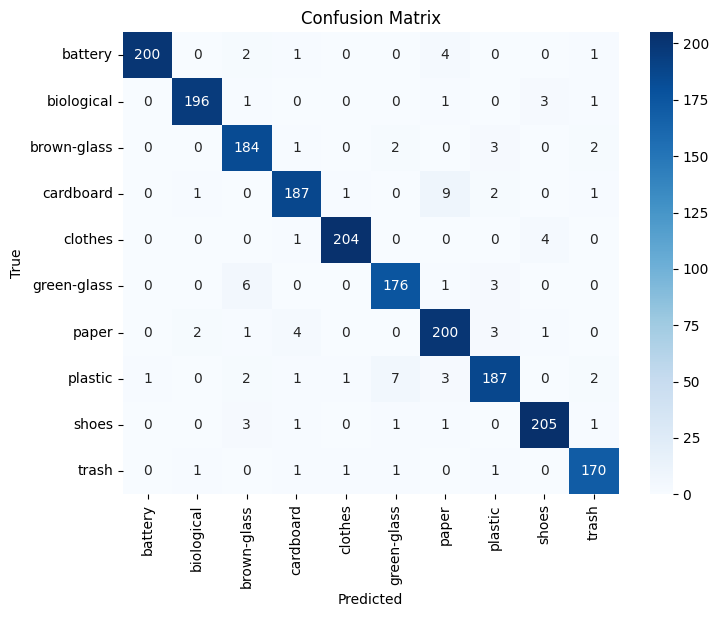

              precision    recall  f1-score   support

     battery       1.00      0.96      0.98       208
  biological       0.98      0.97      0.98       202
 brown-glass       0.92      0.96      0.94       192
   cardboard       0.95      0.93      0.94       201
     clothes       0.99      0.98      0.98       209
 green-glass       0.94      0.95      0.94       186
       paper       0.91      0.95      0.93       211
     plastic       0.94      0.92      0.93       204
       shoes       0.96      0.97      0.96       212
       trash       0.96      0.97      0.96       175

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [22]:
predictions = model6.predict(val_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(val_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Konversi Model

In [23]:
import pathlib

### Saved Model

In [24]:
# Save model as SavedModel
export_dir = '/kaggle/working/Model6/saved_model/'
tf.saved_model.save(model6, export_dir)

### TF-Lite

In [25]:
tflite_model_file = pathlib.Path('/kaggle/working/Model6/best_model_MobileNetV2.tflite')

# Convert SavedModel to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
tflite_model_file.write_bytes(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 115, Total Ops 193, % non-converted = 59.59 %
 * 115 ARITH ops

- arith.constant:  115 occurrences  (f32: 113, i32: 2)



  (f32: 10)
  (f32: 36)
  (f32: 17)
  (f32: 4)
  (f32: 1)

  (f32: 4)
  (f32: 1)
  (f32: 1)


136828152

In [37]:
labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
          'green-glass', 'paper', 'plastic', 'shoes', 'trash']

dir_ = '/kaggle/working/'
label_file_path = os.path.join(dir_, 'label.txt')
with open(label_file_path, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

### TFJS

In [3]:
!pip install tensorflowjs

  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorflow-2.16.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (590.6 MB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.6 MB/s eta 0:00:00 0:00:01
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 68.1 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobu

In [4]:
tfjs_model_dir = '/kaggle/working/tfjs_model/'

!tensorflowjs_converter --input_format=keras best_model_MobileNetV2_5.h5 {tfjs_model_dir}

2024-09-12 09:38:09.859092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 09:38:09.889805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 09:38:09.889879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Inferensi Saved Model

In [28]:
def predict_images_in_folder(folder_path):
    model_path = '/kaggle/working/Model6/saved_model'
    
    # Check if model is loaded correctly
    model = tf.saved_model.load(model_path)
    print("Model loaded successfully.")

    # Check model signatures
    print(model.signatures.keys())
    infer = model.signatures['serving_default']
    print("Inference signature loaded.")

    labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes'
              , 'green-glass', 'paper', 'plastic', 'shoes', 'trash']

    images = []
    titles = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            image_array = np.array(image).astype(np.float32) / 255.0
            image_array = np.expand_dims(image_array, axis=0)

            # Run the model inference and check available output node
            predictions = infer(tf.convert_to_tensor(image_array, dtype=tf.float32))
            print("Prediction keys:", predictions.keys())

            # Once we see the output, we can proceed with extracting predictions
            prediction_output = predictions['dense_7']  # ganti dengan lapisan output  yang sesuai
            predicted_index = np.argmax(prediction_output.numpy(), axis=1)[0]
            predicted_probability = np.max(prediction_output.numpy()) * 100
            predicted_label = labels[predicted_index]

            images.append(image)
            titles.append(f"{predicted_label} ({predicted_probability:.2f}%)")

    num_images = len(images)
    plt.figure(figsize=(27, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

    plt.suptitle("Prediction", y=0.75)
    plt.subplots_adjust(top=0.75)
    plt.show()


Model loaded successfully.
KeysView(_SignatureMap({'serving_default': <ConcreteFunction (*, input_4: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4')) -> Dict[['dense_7', TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_7')]] at 0x7ED337306CE0>}))
Inference signature loaded.
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])
Prediction keys: dict_keys(['dense_7'])


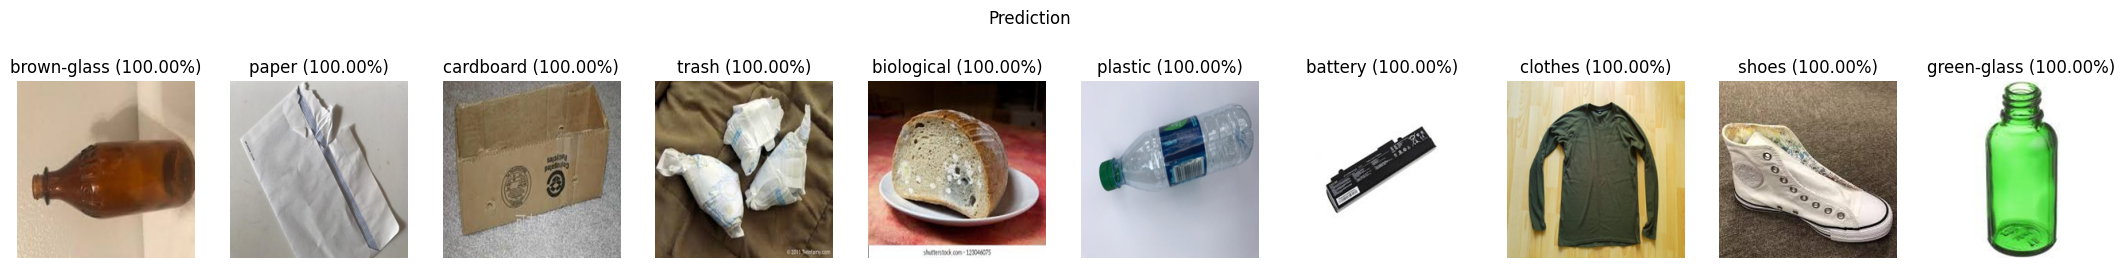

In [29]:
TestPredictImage_path = '/kaggle/input/test-predict-images/Predict_Image'
predict_images_in_folder(TestPredictImage_path)

## Inferensi TFJS

- untuk folder web saya lampirkan di gdrive dengan link tercantum di README.md

![alt text](inferensi_tfjs.gif "Title")

![alt text](web.jpg "Title")

# Download Trained File
- **Karena saya train model pakai kaggle kak, biar selaras gitu, jadi ditampilkan aja ya kak**

In [33]:
!zip -r model6.zip /kaggle/working/Model6

  adding: kaggle/working/Model6/ (stored 0%)
  adding: kaggle/working/Model6/saved_model/ (stored 0%)
  adding: kaggle/working/Model6/saved_model/assets/ (stored 0%)
  adding: kaggle/working/Model6/saved_model/saved_model.pb (deflated 91%)
  adding: kaggle/working/Model6/saved_model/variables/ (stored 0%)
  adding: kaggle/working/Model6/saved_model/variables/variables.index (deflated 76%)
  adding: kaggle/working/Model6/saved_model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: kaggle/working/Model6/saved_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/Model6/best_model_MobileNetV2.tflite (deflated 7%)


In [5]:
!zip -r tfjs_model.zip /kaggle/working/tfjs_model

  adding: kaggle/working/tfjs_model/ (stored 0%)
  adding: kaggle/working/tfjs_model/group1-shard10of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard5of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard17of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard12of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard2of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard1of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard23of33.bin (deflated 8%)
  adding: kaggle/working/tfjs_model/group1-shard7of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard28of33.bin (deflated 8%)
  adding: kaggle/working/tfjs_model/group1-shard26of33.bin (deflated 8%)
  adding: kaggle/working/tfjs_model/group1-shard25of33.bin (deflated 8%)
  adding: kaggle/working/tfjs_model/group1-shard31of33.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard21of33.bin (deflated 8%)
  addi

In [7]:
from IPython.display import FileLink

In [34]:
FileLink('model6.zip')

/kaggle/working/model6.zip

In [38]:
FileLink('label.txt')

/kaggle/working/label.txt

In [31]:
FileLink('best_model_MobileNetV2_5.h5')

/kaggle/working/best_model_MobileNetV2_5.h5

In [8]:
FileLink('tfjs_model.zip')

/kaggle/working/tfjs_model.zip

# Requirements

In [9]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Referensi
- Modul-modul dicoding
- https://www.kaggle.com/datasets/mostafaabla/garbage-classification/code?datasetId=1115942&sortBy=relevance
- https://github.com/dlzcods/animals-classification/tree/main